In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

from sklearn.impute import SimpleImputer

# Feature Extraction

In [2]:
df = pd.read_csv('../data/demand_prediction_book')
df['week'] = pd.to_datetime(df['week'], infer_datetime_format=True)
df['feat_main_page'] = df['feat_main_page'].astype(np.int32)

/tmp/ipykernel_3522/1339075509.py:2: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df['week'] = pd.to_datetime(df['week'], infer_datetime_format=True)


In [3]:
def fill_missing(df, sku):
    impute_grain = ['sku', 'color']
    missing_condition = (df.sku == sku) & (df.color.isna())
    
    imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
    imputer.fit(df[df.sku==sku][impute_grain])
    imputer.transform(df[missing_condition][impute_grain])
    missing = df[missing_condition].index.values
    
    for i in missing:
        df.at[i, 'color'] = imputer.transform(df[missing_condition][impute_grain])[0, 1]
    return df

In [4]:
for sku in set(df[df.color.isna()]['sku']):
    print(f"fill missing for {sku}")
    fill_missing(df, sku)

fill missing for 9
fill missing for 42
fill missing for 43
fill missing for 44


In [5]:
def season(df):
    df['season'] = df['week'].dt.month
    return df

def trend(df):
    start = min(df['week'].dt.year)
    df['trend'] = df['week'].dt.year - start
    return df

df = season(df)
df = trend(df)

In [6]:
def one_hot(df, cols=['season', 'functionality', 'color', 'vendor']):
    return pd.get_dummies(df, columns=cols, drop_first=True, dtype=np.int32)

In [7]:
df  = one_hot(df)

In [8]:
def lag_price(df):
    df['price-1'] = df.groupby(['sku'])['price'].shift(1)
    df['price-2'] = df.groupby(['sku'])['price'].shift(2)
    return df.dropna(subset=['price-1', 'price-2'])

In [9]:
df = lag_price(df)

In [10]:
df = df.sort_values(by=['sku', 'week']).reindex()

In [11]:
df.to_csv('clean_demand_prediction_book.csv')

# Modeling

In [12]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from tensorflow.keras.layers import * 
from tensorflow.keras.models import * 
from tensorflow.keras.optimizers import * 
from tensorflow.keras.metrics import * 


In [13]:
df = pd.read_csv('clean_demand_prediction_book.csv', index_col=0)

In [14]:
SKU = list(set(df.sku))

In [15]:
def sequences(df):
    df = df.sort_values(by='week')
    seasons = [col for col in df.columns if col.startswith('season_')]
    vendors = [col for col in df.columns if col.startswith('vendor_')]
    scaled = StandardScaler().fit_transform(df[['weekly_sales', 'price', 'price-1', 'price-2', 'trend'] + seasons + vendors])
    X = []
    X_meta = []
    y = []
    for i in range(4, len(scaled) - 4):
        X.append(scaled[i-4:i])
        X_meta.append(scaled[i:i+4, 4:])
        y.append(scaled[i:i+4, 0])
    return np.array(X), np.array(X_meta), np.array(y)

In [16]:
X = []
X_meta = []
y = []
for sku in SKU:
    _X, _X_meta, _y = sequences(df[df.sku==sku])
    X.append(_X)
    X_meta.append(_X_meta)
    y.append(_y.reshape((90, 4, 1)))
X = np.dstack(X)
X_meta = np.dstack(X_meta)
y = np.dstack(y)

In [17]:
X.shape, X_meta.shape, y.shape

((90, 4, 1100), (90, 4, 924), (90, 4, 44))

In [18]:
def enc_dec(hidden=64):
    i_hist = Input((4, 1100))
    i_meta = Input((4, 924))

    x_hist = TimeDistributed(Dense(32))(i_hist)
    x_meta = TimeDistributed(Dense(32))(i_meta
                                       )
    x = LSTM(hidden)(x_hist)
    x = RepeatVector(4)(x)
    x = Concatenate()([x, x_meta])
    
    x = LSTM(hidden, return_sequences=True)(x)
    x = Dropout(0.1)(x)
    x = TimeDistributed(Dense(44))(x)
    return Model(inputs=[i_hist, i_meta], outputs=[x])


model = enc_dec()
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 4, 1100)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed    │ (None, 4, 32)     │     35,232 │ input_layer[0][0] │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 64)        │     24,832 │ time_distributed… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 4, 924)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector       │ (None, 4, 64)     │          0 │ lstm[0][0]        │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_1  │ (None, 4, 32)     │     29,600 │ input_layer_1[0]… │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 4, 96)     │          0 │ repeat_vector[0]… │
│ (Concatenate)       │                   │            │ time_distributed… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ (None, 4, 64)     │     41,216 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 4, 64)     │          0 │ lstm_1[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_2  │ (None, 4, 44)     │      2,860 │ dropout[0][0]     │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 133,740 (522.42 KB)

 Trainable params: 133,740 (522.42 KB)

 Non-trainable params: 0 (0.00 B)

In [19]:
X_train, X_test, X_train_meta, X_test_meta, y_train, y_test = train_test_split(X, X_meta, y, test_size=0.3)

In [20]:
X_train.shape, X_train_meta.shape, y_train.shape

((63, 4, 1100), (63, 4, 924), (63, 4, 44))

In [21]:
opt = Adam(learning_rate=0.01)
model.compile(loss='mean_squared_error', optimizer=opt, metrics=[RootMeanSquaredError()])
hist = model.fit([X_train, X_train_meta], y_train, batch_size=32, epochs=50, validation_data=([X_test, X_test_meta], y_test), callbacks=[])


Epoch 1/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 428ms/step - loss: 0.9922 - root_mean_squared_error: 0.9959 - val_loss: 0.7925 - val_root_mean_squared_error: 0.8902
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.8302 - root_mean_squared_error: 0.9111 - val_loss: 0.6954 - val_root_mean_squared_error: 0.8339
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.7241 - root_mean_squared_error: 0.8510 - val_loss: 0.6443 - val_root_mean_squared_error: 0.8027
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.6776 - root_mean_squared_error: 0.8231 - val_loss: 0.6075 - val_root_mean_squared_error: 0.7794
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.6226 - root_mean_squared_error: 0.7891 - val_loss: 0.5833 - val_root_mean_squared_error: 0.7638
Epoch 6/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.5803 - root_mean_squared_error: 0.7616 - val_loss: 0.5577 - val_root_mean_squared_error: 0.7468
Epoch 7/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.5773 - roo

In [22]:
import matplotlib.pyplot as plt

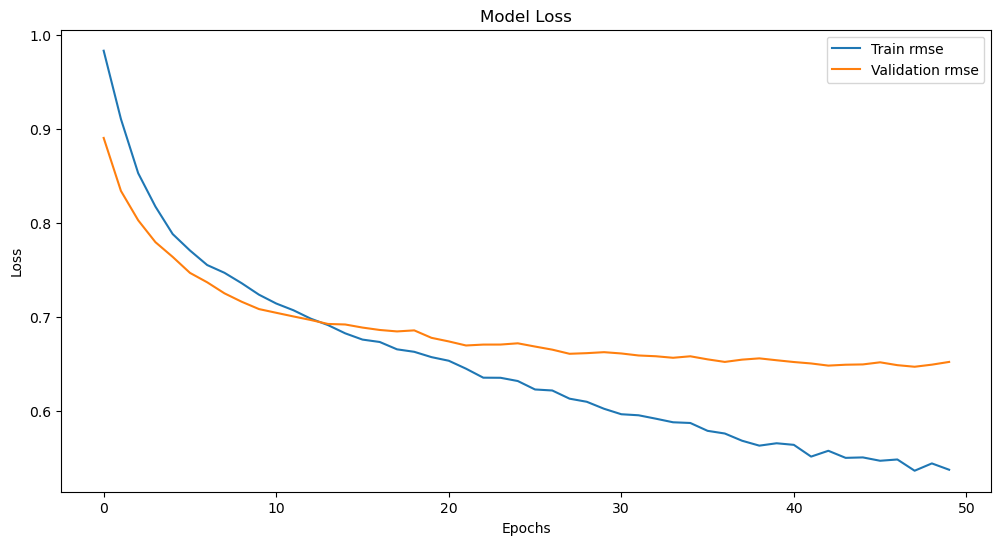

In [23]:
plt.figure(figsize=(12, 6))
plt.plot(hist.history['root_mean_squared_error'], label='Train rmse')
plt.plot(hist.history['val_root_mean_squared_error'], label='Validation rmse')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [26]:
_y_test = model([X_test, X_test_meta])

In [27]:
_y_test.shape, y_test.shape

(TensorShape([27, 4, 44]), (27, 4, 44))

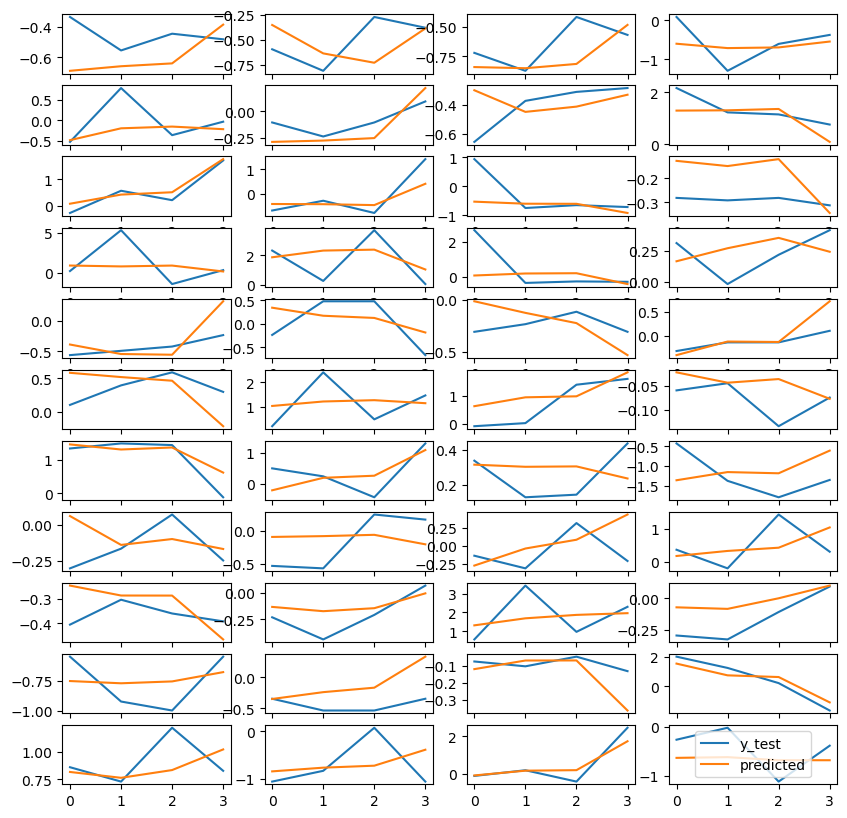

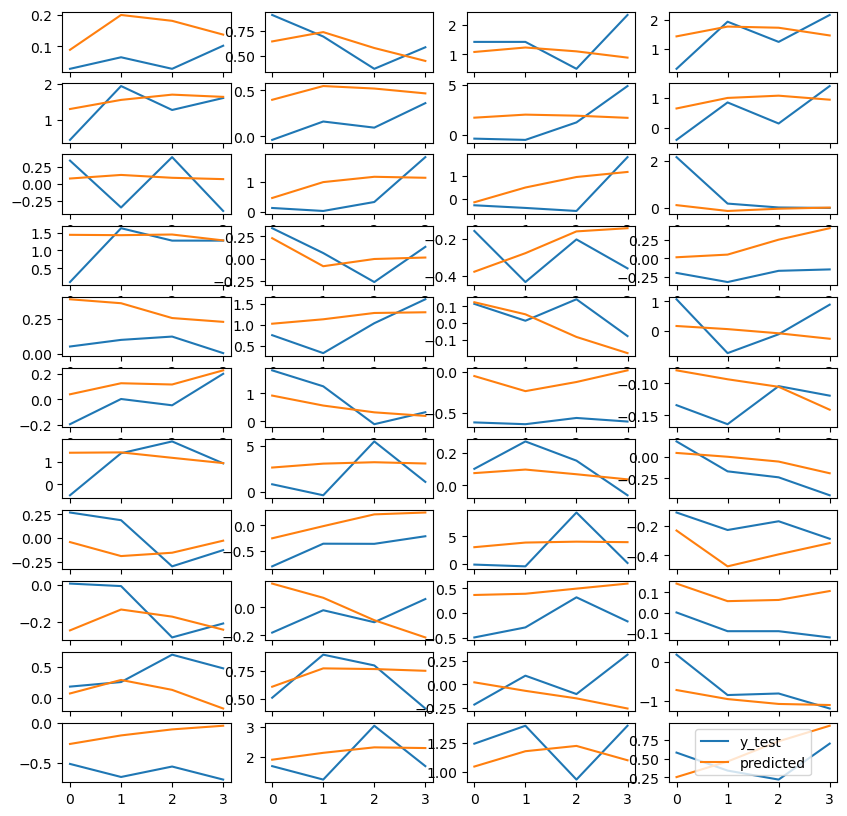

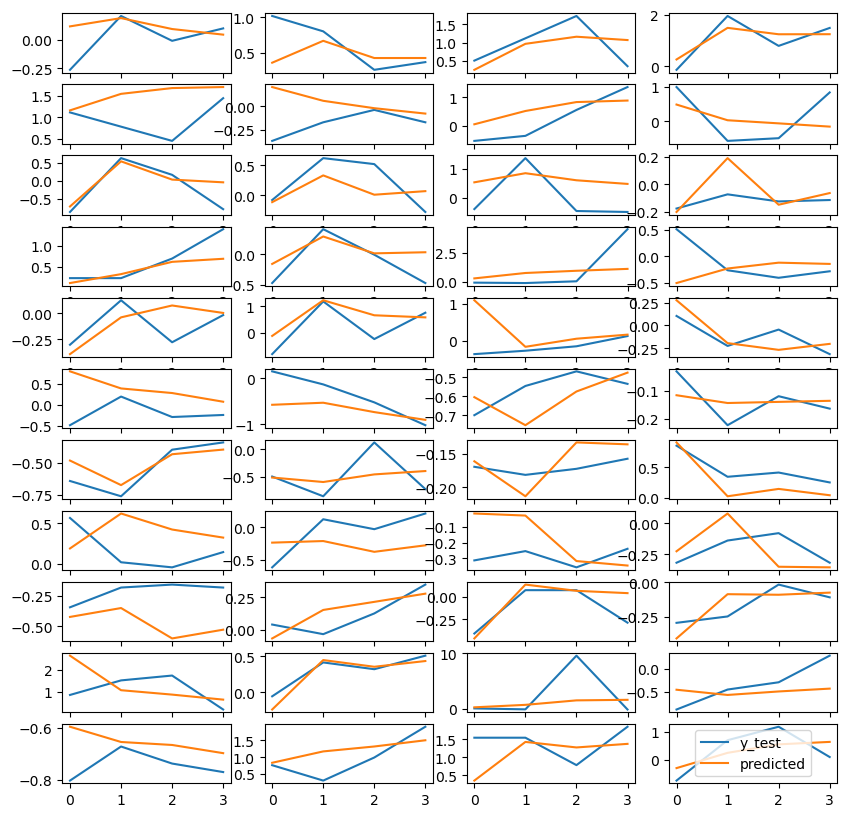

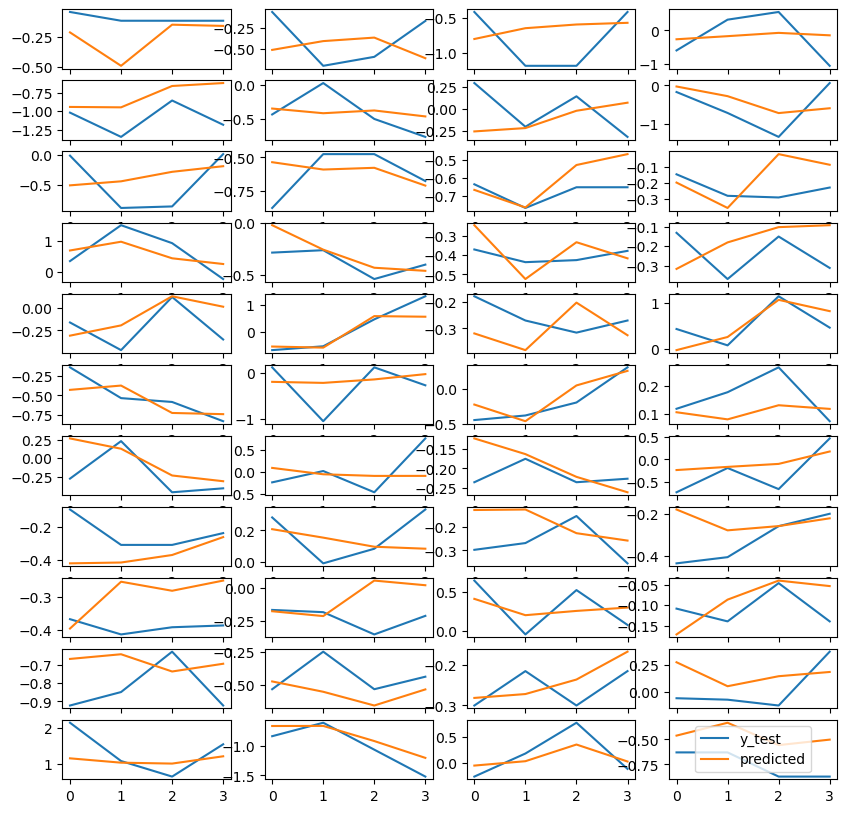

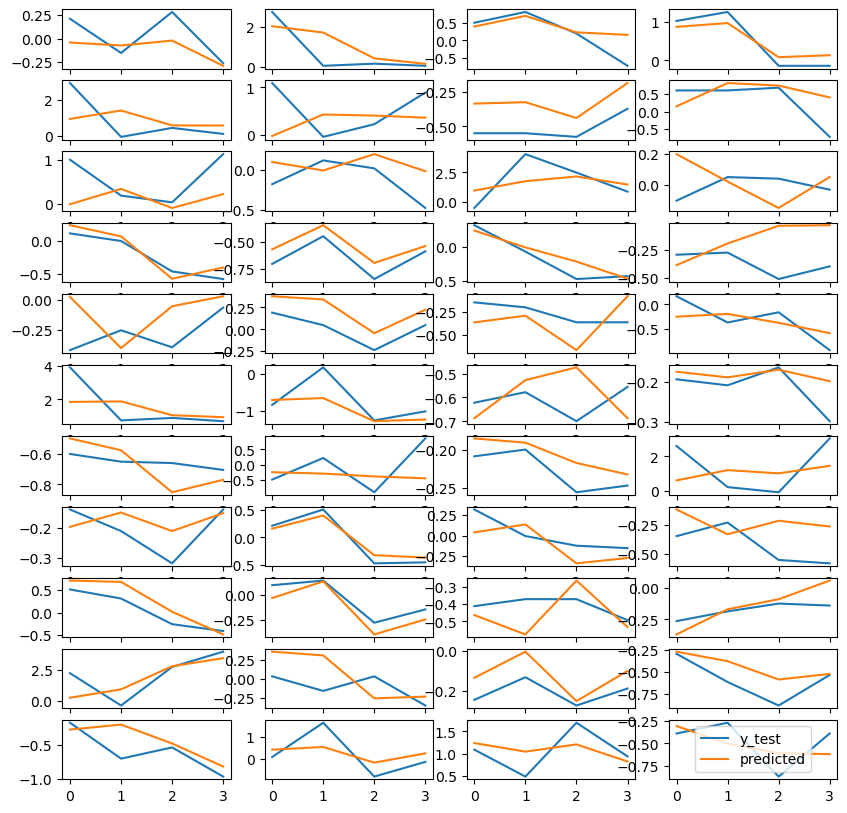

In [39]:
for j in range(0, 5): 
    plt.figure(figsize=(10, 10))
    for i in range(0, 44):
        plt.subplot(11, 4, i + 1)
        plt.plot(y_test[j, :, i], label = 'y_test')
        plt.plot(_y_test[j, :, i], label = 'predicted')
    plt.legend()
    plt.show()